In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import time

import torch
import pickle
import qgrid
from librosa.effects import harmonic
from librosa.util.exceptions import ParameterError
from madmom.audio.chroma import DeepChromaProcessor

import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

from scipy.io import wavfile
import scipy.fftpack as fftpack

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *
from python.signal_processing import *

## Load data

In [2]:
data = pd.read_csv('../data/data.csv', index_col=0)

## Calculate spectrogram (frame size 2048)

In [3]:
sr = 44100
frame_size = 2048
frame_rate = 100
hop_size = sr/frame_rate
window = np.hamming(frame_size) 
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sr)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')

In [4]:
files = data['file'][data['data_set'] == 6]

start = time.time()
for i, file in enumerate(files):  
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r") 
    idx = files.index[i]
    _, dataset = index_to_file(idx)
    
    signal = get_audio(idx)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    frames = []    

    # Slice audio into frames
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))

    # Compute FFT    
    fft = np.empty((num_frames, num_fft_bins), np.complex64)
    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

    abs_fft = np.square(np.abs(fft))

    filt_spec = np.log(np.dot(abs_fft, filterbank.T) + 1.0)
    
    filt_spec = filt_spec[:,~np.all(filt_spec == 0, axis=0)]

    feature = torch.tensor(filt_spec, dtype=torch.float32) 
      
    pickle.dump(feature, open('../data/inputs/{}/{}.npy'.format(dataset, file), 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 26 of 26
Elapsed time: 0 min and 7 s


In [8]:
# Visualization

plt.figure(figsize=(10,3))

plt.imshow(np.array(filt_spec).T, origin='lower', aspect='auto',cmap='jet');
plt.colorbar(format='%.1f');
plt.xlabel('Time [s]');
plt.ylabel('Freq');
plt.tight_layout();

# for ann in predictions:
#     plt.axvline(x=ann, color='w', linestyle=':', linewidth=2)
# plt.xlim(start, end)

## Chroma

In [7]:
idx = 705

sr, signal = read_wav(idx, normalize=True)
annotations = get_annotations(idx)
fmin = note_to_hz('C1')

print('Process pitchgram')
pitchgram = np.abs(cqt(y=signal, sr=sr, hop_length=512, fmin=fmin, 
                   n_bins=7*36, bins_per_octave=36, tuning=None))

print('Process chroma cqt')
chroma = chroma_cqt(y=signal, sr=sr, hop_length=512, fmin=fmin,
                tuning=None, n_chroma=12, n_octaves=7, bins_per_octave=36)

print('Process chroma crp')
chroma2 = chroma_crp(y=signal, sr=sr, hop_length=512, fmin=fmin,
                     n_chroma=12, n_octaves=7, bins_per_octave=36)
chroma_mod2 = chroma2.clip(min=0)/np.max(chroma2)

# print('Process chroma cho')
# chroma3 = chroma_cho(y=signal, sr=sr, hop_length=512, fmin=fmin, M=25, tau=1, 
#                      theta=50, n_chroma=12, n_octaves=7, bins_per_octave=36)
# chroma_mod3 = chroma3.clip(min=0)/np.max(chroma3)

print('Process deep chroma')
dcp = DeepChromaProcessor()
deep_chroma = dcp(signal)

Process pitchgram
Process chroma cqt
Process chroma crp
Process deep chroma


<IPython.core.display.Javascript object>


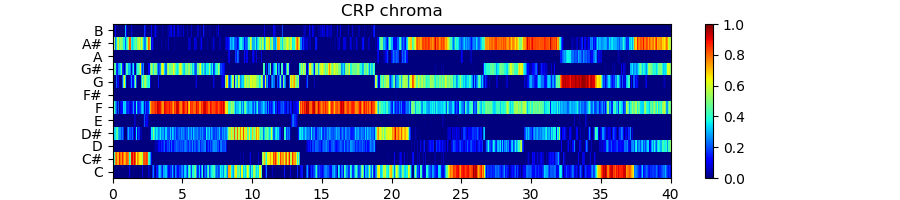

<IPython.core.display.Javascript object>


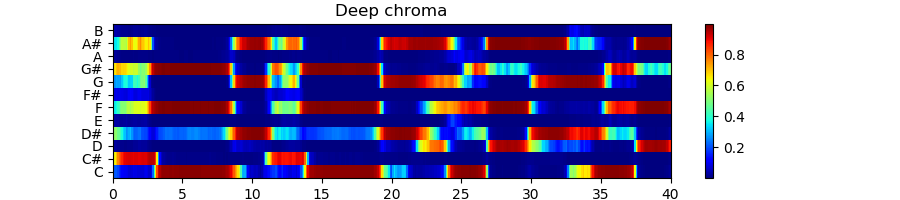

In [8]:
# Visualization

plt.figure(figsize=(9,2))
plt.title('CRP chroma')
plt.imshow(chroma_mod2, origin='lower', aspect='auto', cmap='jet', extent=(0, len(signal)/sr, -0.5, 11.5))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']);
# for ann in annotations:
#         plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);

# plt.figure(figsize=(9,2))
# plt.title('Cho chroma')
# plt.imshow(chroma_mod3, origin='lower', aspect='auto', cmap='jet', extent=(0, len(signal)/sr, -0.5, 11.5))
# plt.colorbar(format='%.1f');
# plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']);
# # for ann in annotations:
# #         plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);

plt.figure(figsize=(9,2))
plt.title('Deep chroma')
plt.imshow(deep_chroma.T, origin='lower', aspect='auto', cmap='jet', extent=(0, len(signal)/sr, -0.5, 11.5))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']);
# for ann in annotations:
#         plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);

In [9]:
sr, signal = read_wav(idx, normalize=False)        
ipd.Audio(signal, rate=sr)

<IPython.core.display.Javascript object>


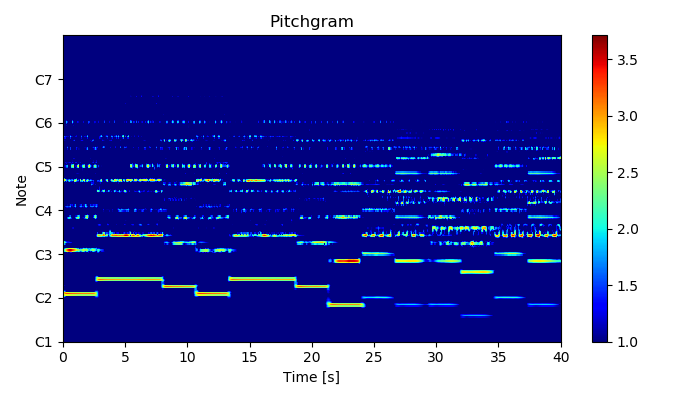

In [12]:
# plot pitchgram 

pitchgram_mod = np.log(2*pitchgram+1)
pitchgram_mod = pitchgram_mod.clip(min=1)[0:252]

plt.figure(figsize=(7,4))
plt.title('Pitchgram')
plt.imshow(pitchgram_mod, origin='lower', aspect='auto', cmap='jet', 
           extent=(0, len(signal)/sr, 0, pitchgram_mod.shape[0]))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(0,pitchgram.shape[0],36), ['C1','C2','C3','C4','C5','C6','C7'])
# for ann in annotations:
#         plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);
plt.xlabel('Time [s]');
plt.ylabel('Note');
plt.tight_layout();

## Calculalte labels

In [5]:
sr = 44100
frame_rate = 100
hop_size = sr/frame_rate

In [7]:
files = data['file'][data['data_set'] == 6]
# files = data['file']

start = time.time()
for i, file in enumerate(files):
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    idx = files.index[i]
    _, dataset = index_to_file(idx)
    
    signal = get_audio(idx)
    annotations = get_annotations(idx)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    labels = quantize_events(annotations, fps=frame_rate, length=num_frames)
    pickle.dump(labels, open('../data/labels/{}/{}.npy'.format(dataset, file), 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

## Process files (3 frame sizes)

In [6]:
sr = 44100
frame_sizes = [1024, 2048, 4096]
frame_rate = 100
hop_size = sr/frame_rate
window = [np.hamming(frame_size) for frame_size in frame_sizes]
num_fft_bins = [frame_size >> 1 for frame_size in frame_sizes]

bin_frequencies = []
for i in range(len(frame_sizes)):
    bin_frequencies.append(np.fft.fftfreq(frame_sizes[i], 1. / sr)[:num_fft_bins[i]])
    
filterbank = []
for i in range(len(frame_sizes)):
    filterbank.append(np.array(create_filterbank(bin_frequencies[i], num_fft_bins[i]), dtype='float32'))

In [20]:
files = data['file'][data['data_set'] == 5]
indices = list(data['idx'][data['data_set'] == 5])

start = time.time()
for i, file in enumerate(files):  
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r") 
    
    signal = get_audio(indices[i])
    _, dataset = index_to_file(indices[i]) 
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    feature = []
    
    for j, frame_size in enumerate(frame_sizes):  
        frames = []    
        # Slice audio into frames
        for index in range(num_frames):
            frames.append(signal_frame(signal, index, frame_size, hop_size))
        # Compute FFT    
        fft = np.empty((num_frames, num_fft_bins[j]), np.complex64)
        for f, frame in enumerate(frames):
            fft_signal = np.multiply(frame, window[j])
            fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins[j]]

        abs_fft = np.square(np.abs(fft))
        filt_spec = np.log(np.dot(abs_fft, filterbank[j].T) + 1.0)
        shift_length = np.int(frame_size/100.)   
        median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
        median = np.insert(median, 0, filt_spec, axis=0)
        median = np.median(median, axis=0)
        
        diff_spec = half_wave_rectifier(filt_spec - median)
        diff_spec[:shift_length,:] = 0               
        feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
        feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    feature_vec = torch.cat(feature, 1)
    pickle.dump(feature_vec, open('../data/inputs/{}/{}.npy'.format(dataset, file), 'wb'), protocol=2)     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 179 of 179
Elapsed time: 14 min and 3 s


## Old chroma vector

In [44]:
# functions

def estimate_tuning(abs_fft=None, sr=44100, n_fft=2048, resolution=0.01):
    pitch, mag = piptrack(abs_fft=abs_fft, sr=sr, n_fft=n_fft)
    pitch_mask = pitch > 0

    if pitch_mask.any():
        threshold = np.median(mag[pitch_mask])
    else:
        threshold = 0.0

    return pitch_tuning(pitch[(mag >= threshold) & pitch_mask],
                        resolution=resolution)


def piptrack(abs_fft=None, sr=44100, n_fft=2048,
             fmin=150.0, fmax=4000.0, threshold=0.1):  
    fft_freqs = np.fft.fftfreq(n_fft, 1. / sr)[:abs_fft.shape[0]]

    # poarabolic interpolation 
    # https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
    avg = 0.5 * (abs_fft[2:] - abs_fft[:-2])
    shift = 2 * abs_fft[1:-1] - abs_fft[2:] - abs_fft[:-2]

    # suppress divide-by-zeros
    shift = avg / (shift + (np.abs(shift) < tiny(shift)))

    # pad back up to the same shape as abs_fft
    avg = np.pad(avg, ([1, 1], [0, 0]), mode='constant')
    shift = np.pad(shift, ([1, 1], [0, 0]), mode='constant')

    dskew = 0.5 * avg * shift

    pitches = np.zeros_like(abs_fft)
    mags = np.zeros_like(abs_fft)

    freq_mask = ((fmin <= fft_freqs) & (fft_freqs < fmax)).reshape((-1, 1))

    # compute the column-wise local max of abs_fft after thresholding
    idx = np.argwhere(freq_mask &
                      localmax(abs_fft * (abs_fft > (threshold * abs_fft.max(axis=0)))))

    # store pitch and magnitude
    pitches[idx[:, 0], idx[:, 1]] = ((idx[:, 0] + shift[idx[:, 0], idx[:, 1]])
                                     * float(sr) / n_fft)
    mags[idx[:, 0], idx[:, 1]] = (abs_fft[idx[:, 0], idx[:, 1]]
                                  + dskew[idx[:, 0], idx[:, 1]])
    
    return pitches, mags


def pitch_tuning(frequencies, resolution=0.01):   
    bins_per_octave=12
    frequencies = np.atleast_1d(frequencies)
    frequencies = frequencies[frequencies > 0]

    # compute the residual relative to the number of bins
    residual = np.mod(bins_per_octave * hz_to_octs(frequencies), 1.0)

    # center the residual 
    residual[residual >= 0.5] -= 1.0

    bins = np.linspace(-0.5, 0.5, int(np.ceil(1. / resolution)) + 1)

    counts, tuning = np.histogram(residual, bins)

    return tuning[np.argmax(counts)]


def chroma(sr, n_fft, n_chroma=12, A440=440.0, ctroct=5.0,
           octwidth=2, norm=2, base_c=True):
    
    wts = np.zeros((n_chroma, n_fft))

    # Get the FFT bins, not counting the DC component
    frequencies = np.linspace(0, sr, n_fft, endpoint=False)[1:]

    frqbins = n_chroma * hz_to_octs(frequencies, A440)

    # make up a value for the 0 Hz bin = 1.5 octaves below bin 1
    # (so chroma is 50% rotated from bin 1, and bin width is broad)
    frqbins = np.concatenate(([frqbins[0] - 1.5 * n_chroma], frqbins))

    binwidthbins = np.concatenate((np.maximum(frqbins[1:] - frqbins[:-1],
                                              1.0), [1]))

    D = np.subtract.outer(frqbins, np.arange(0, n_chroma, dtype='d')).T

    n_chroma2 = np.round(float(n_chroma) / 2)

    # Project into range -n_chroma/2 .. n_chroma/2
    # add on fixed offset of 10*n_chroma to ensure all values passed to
    # rem are positive
    D = np.remainder(D + n_chroma2 + 10*n_chroma, n_chroma) - n_chroma2

    # Gaussian bumps - 2*D to make them narrower
    wts = np.exp(-0.5 * (2*D / np.tile(binwidthbins, (n_chroma, 1)))**2)

    # normalize each column
    wts = normalize(wts, norm=norm, axis=0)

    # Maybe apply scaling for fft bins
    if octwidth is not None:
        wts *= np.tile(
            np.exp(-0.5 * (((frqbins/n_chroma - ctroct)/octwidth)**2)),
            (n_chroma, 1))

    if base_c:
        wts = np.roll(wts, -3, axis=0)

    # remove aliasing columns, copy to ensure row-contiguity
    return np.ascontiguousarray(wts[:, :int(n_fft/2)])


def normalize(S, norm=np.inf, axis=0, threshold=None, fill=None):
    # Avoid div-by-zero
    if threshold is None:
        threshold = tiny(S)

    elif threshold <= 0:
        raise ParameterError('threshold={} must be strictly '
                             'positive'.format(threshold))

    if fill not in [None, False, True]:
        raise ParameterError('fill={} must be None or boolean'.format(fill))

    if not np.all(np.isfinite(S)):
        raise ParameterError('Input must be finite')

    # All norms only depend on magnitude, let's do that first
    mag = np.abs(S).astype(np.float)

    # For max/min norms, filling with 1 works
    fill_norm = 1

    if norm == np.inf:
        length = np.max(mag, axis=axis, keepdims=True)

    elif norm == -np.inf:
        length = np.min(mag, axis=axis, keepdims=True)

    elif norm == 0:
        if fill is True:
            raise ParameterError('Cannot normalize with norm=0 and fill=True')

        length = np.sum(mag > 0, axis=axis, keepdims=True, dtype=mag.dtype)

    elif np.issubdtype(type(norm), np.number) and norm > 0:
        length = np.sum(mag**norm, axis=axis, keepdims=True)**(1./norm)

        if axis is None:
            fill_norm = mag.size**(-1./norm)
        else:
            fill_norm = mag.shape[axis]**(-1./norm)

    elif norm is None:
        return S

    else:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # indices where norm is below the threshold
    small_idx = length < threshold

    Snorm = np.empty_like(S)
    if fill is None:
        # Leave small indices un-normalized
        length[small_idx] = 1.0
        Snorm[:] = S / length

    elif fill:
        # If we have a non-zero fill value, we locate those entries by
        # doing a nan-divide.
        # If S was finite, then length is finite (except for small positions)
        length[small_idx] = np.nan
        Snorm[:] = S / length
        Snorm[np.isnan(Snorm)] = fill_norm
    else:
        # Set small values to zero by doing an inf-divide.
        # This is safe (by IEEE-754) as long as S is finite.
        length[small_idx] = np.inf
        Snorm[:] = S / length

    return Snorm


def tiny(x):
    # Make sure we have an array view
    x = np.asarray(x)

    # Only floating types generate a tiny
    if np.issubdtype(x.dtype, np.floating) or np.issubdtype(x.dtype, np.complexfloating):
        dtype = x.dtype
    else:
        dtype = np.float32

    return np.finfo(dtype).tiny


def localmax(x, axis=0):
    paddings = [(0, 0)] * x.ndim
    paddings[axis] = (1, 1)

    x_pad = np.pad(x, paddings, mode='edge')

    inds1 = [slice(None)] * x.ndim
    inds1[axis] = slice(0, -2)

    inds2 = [slice(None)] * x.ndim
    inds2[axis] = slice(2, x_pad.shape[axis])

    return (x > x_pad[tuple(inds1)]) & (x >= x_pad[tuple(inds2)])


def hz_to_octs(frequencies, A440=440.0):
    return np.log2(np.asanyarray(frequencies) / (float(A440) / 16))

In [45]:
files = [data.at[27,'file']]
annotations = get_annotations(data.at[27,'file'])

In [71]:
frame_size = 2048
n_fft = frame_size
window = np.hamming(frame_size)
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sample_rate)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')
fft_freqs = bin_frequencies
n_chroma = 48

In [72]:
start = time.time()
for i, file in enumerate(files):    
#     print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    signal = get_audio(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))

    frames = []    

    # slice audio into frames
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))

    # compute FFT    
    fft = np.empty((num_frames, num_fft_bins), np.complex64)

    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

    abs_fft = np.square(np.abs(fft))
    
    tuning = estimate_tuning(abs_fft=abs_fft.T, sr=sr)

    A440 = 440.0 * 2.0**(float(tuning) / n_chroma)

    chromafb = chroma(sr, frame_size, n_chroma, A440)

    raw_chroma = np.dot(chromafb, abs_fft.T)

    chroma_vector = normalize(raw_chroma, norm=np.inf, axis=0)
    
    shift_length = np.int(frame_size/60.)
    
    filt_spec = chroma_vector.T
        
    median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
    median = np.insert(median, 0, filt_spec, axis=0)
    median = np.median(median, axis=0)

    diff_spec = half_wave_rectifier(filt_spec - median)
    diff_spec[:shift_length,:] = 0
    
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))


Elapsed time: 0 min and 1 s


## Example 

Text(0.5,0,'Time [s]')

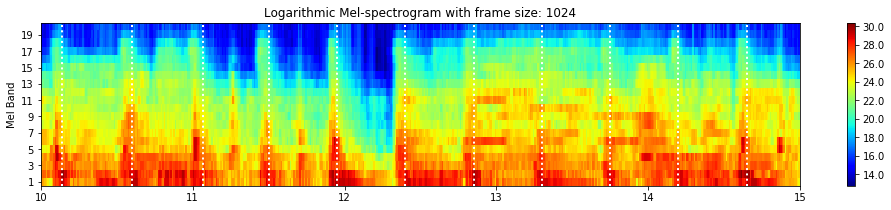

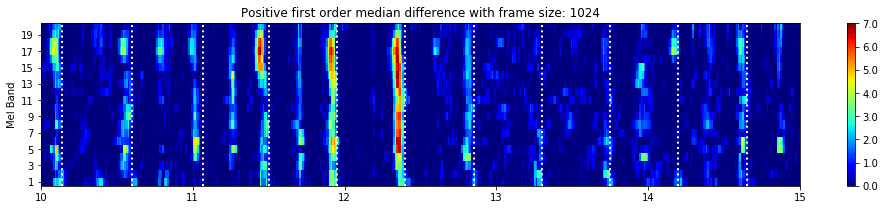

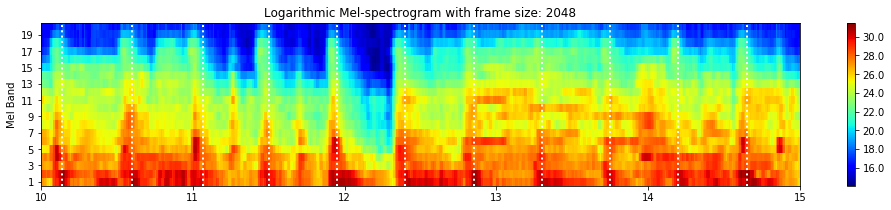

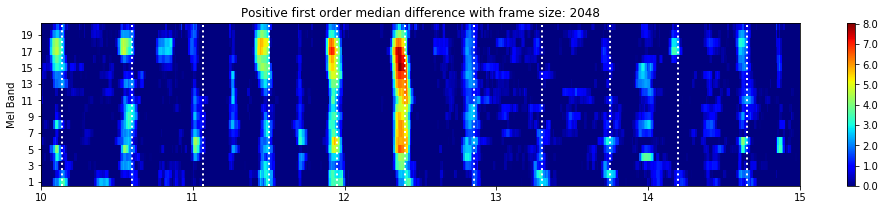

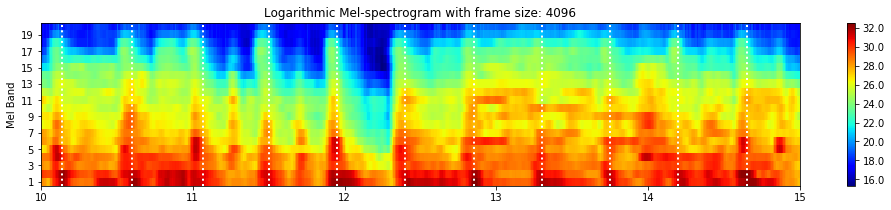

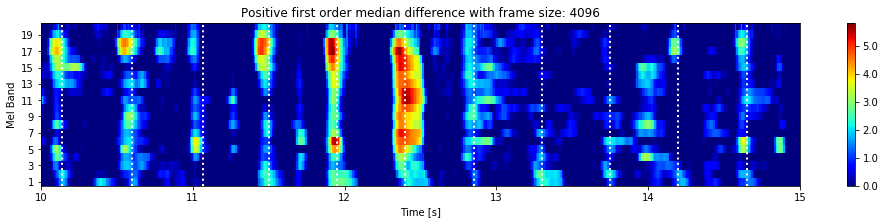

In [30]:
index = 260

input = get_input(data.at[index,'file'])
annotations = get_annotations(data.at[index,'file'])
predictions = get_predictions(data.at[index,'file'])

start = 10
end = 15
num_bands = 20
frame_rate = 100

title = ['Logarithmic Mel-spectrogram with frame size: 1024', 
         'Positive first order median difference with frame size: 1024',
         'Logarithmic Mel-spectrogram with frame size: 2048', 
         'Positive first order median difference with frame size: 2048',
         'Logarithmic Mel-spectrogram with frame size: 4096', 
         'Positive first order median difference with frame size: 4096']

for i in range(6):
    plt.figure(figsize=(17,3))
    plt.title(title[i])

    plt.imshow(np.array(input).T[i*20:(i+1)*20,start*frame_rate:end*frame_rate], 
               extent=(start,end, 0.5, num_bands+0.5),
               origin='lower', aspect='auto',cmap='jet');
    plt.yticks(np.arange(1,20,2));
    plt.ylim(0.5,num_bands+0.5)

    plt.colorbar(format='%.1f');
    
    plt.ylabel('Mel Band');

    for ann in predictions:
        plt.axvline(x=ann, color='w', linestyle=':', linewidth=2)
    plt.xlim(start, end)

plt.xlabel('Time [s]')


Wie sollen die Features normalisiert werden? <br>
Mit Hinblick auf die Eingangsdaten?

## Appendix

In [14]:
# Median Bildung
a = np.random.randn(5,3)
# print('a:\n', a, '\n')

shift_length = 5

median = [np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-shift,:] for shift in range(1, shift_length+1)]
median = np.insert(median, 0, a, axis=0)

# print('median:\n', median)

median = np.median(median, axis=0)

# shift = 1
# np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-1,:]